# Learning goals
After this week's lesson you should be able to:
- Perform an overlay analysis
- Reclassify data
- Perform a spatial join (Refresher)

This week's lessons are adapted from:
- [Automating GIS Processes Lesson 3](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-3/overview.html)
- [Automating GIS Processes Lesson 4](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-4/overview.html)

In [1]:
# We are going to start importing the libraries we need
# all in one cell. 
# It is a good practice to keep all the imports in one cell so that
# we can easily see what libraries we are using in the notebook.
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt

os.getcwd()

/var/folders/_7/lymm6gzn0cd9kkph02m8lhsc0000gn/T/ipykernel_78374/1246542324.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


'/Users/tangjiaxuan/Library/CloudStorage/OneDrive-个人/Cornell/4_2023_Spring/CRP5680/4680_5680_intro_uds/Week3'

# 1. Overlay Analysis
Overlay analyses are GIS operations in which two or more vector layers are combined to produce new geometries. Typical overlay operations include union, intersection, and difference - named after the result of the combination of two layers.

</figure>
<img src="https://autogis-site.readthedocs.io/en/latest/_images/overlay-operations_700x200px.svg" alt="drawing" width="700" style="display: block; margin: 0 auto"/>
</figure>

## 1.1 Loading data
Let's say we wanted to study which [neighborhoods](https://data.cityofnewyork.us/City-Government/NTA-map/d3qk-pfyz) in NYC are more vulnerable to flooding. Here, we will measure vulnerability as the areal coverage of the neighborhood by the [NYC Stormwater Flood Map](https://data.cityofnewyork.us/City-Government/NYC-Stormwater-Flood-Map-Moderate-Flood-with-2050-/5rzh-cyqd). 

Let's download two datasets and put it into our current folder: 
- The [Neighborhood Tabulation Areas](https://data.cityofnewyork.us/City-Government/NTA-map/d3qk-pfyz) (make sure to download the shapefile)
- [NYC Stormwater Flood Map - Moderate Flood with 2050 Sea Level Rise](https://data.cityofnewyork.us/City-Government/NYC-Stormwater-Flood-Map-Moderate-Flood-with-2050-/5rzh-cyqd) There is a zip file in on this page and you will have to unzip to read a `.gdb` file

In [2]:
nta = gpd.read_file('NTA map.zip')

In [3]:
nta.head()

borocode  boroname countyfips ntacode               ntaname    shape_area  \
0       3.0  Brooklyn        047    BK43               Midwood  3.579964e+07   
1       3.0  Brooklyn        047    BK75               Bedford  3.262983e+07   
2       2.0     Bronx        005    BX40         Fordham South  6.307284e+06   
3       3.0  Brooklyn        047    BK88          Borough Park  5.400502e+07   
4       3.0  Brooklyn        047    BK96  Rugby-Remsen Village  3.270695e+07   

     shape_leng                                           geometry  
0  27996.591274  POLYGON ((-73.94733 40.62917, -73.94687 40.626...  
1  29992.919174  POLYGON ((-73.94193 40.70073, -73.94439 40.700...  
2  15878.272921  POLYGON ((-73.89138 40.86170, -73.89106 40.861...  
3  39247.227722  POLYGON ((-73.97605 40.63128, -73.97717 40.630...  
4  30957.853395  POLYGON ((-73.90856 40.65210, -73.90945 40.651...

<AxesSubplot: >

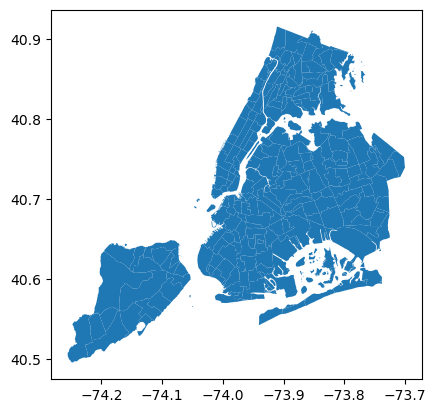

In [4]:
nta.plot()

In [5]:
## I'm sorry this file is a pain 
## It is a .gdb file, which is a geodatabase file in ArcGIS
## It only has one layer, so we can just read it in with layer=0
## We can also use the driver='FileGDB' to tell geopandas that it is a geodatabase file
## Though Geopandas will infer the file format from the file extension, so we don't need to specify the driver 



flood_2050 = gpd.read_file("NYC_Stormwater_Flood_Map_-_Moderate_Flood_with_2050_Sea_Level_Rise/NYC Stormwater Flood Map - Moderate Flood with 2050 Sea Level Rise.gdb",
                        driver='FileGDB', 
                        layer=0)
                        
# And this file name is terrible. 
# Ok enough griping. 

In [6]:
flood_2050.head()

Flooding_Category  Shape_Length    Shape_Area  \
0                  1  7.065402e+06  8.657528e+07   
1                  2  2.877719e+06  4.613496e+07   
2                  3  4.994691e+06  1.389420e+08   

                                            geometry  
0  MULTIPOLYGON Z (((917232.601 120841.554 0.000,...  
1  MULTIPOLYGON Z (((917155.062 120828.741 0.000,...  
2  MULTIPOLYGON Z (((915689.174 120243.672 0.000,...

This is unusual. There are only three rows in the dataset! Judging by the `Flooding_Category` column an the fact that each entry in the `geometry` column is a **MULTIPOLYGON** (we're going to ignore the Z part. This is actually a 3D polygon, but we won't work with the third dimension in this example.)

Looking, in the data dictionary for the flood data, which should be the `.xlsx` file in the unzipped folder we can see that these are the following categories definitions: 
- 1 - Nuisance Flooding (greater or equal to 4 in. and less than 1 ft.)
- 2 - Deep and Contiguous Flooding (1 ft. and greater)
- 3 - Future High Tides 2050

I'm going to make a quick categorical plot to get a sense of what the data may look like. 

<AxesSubplot: >

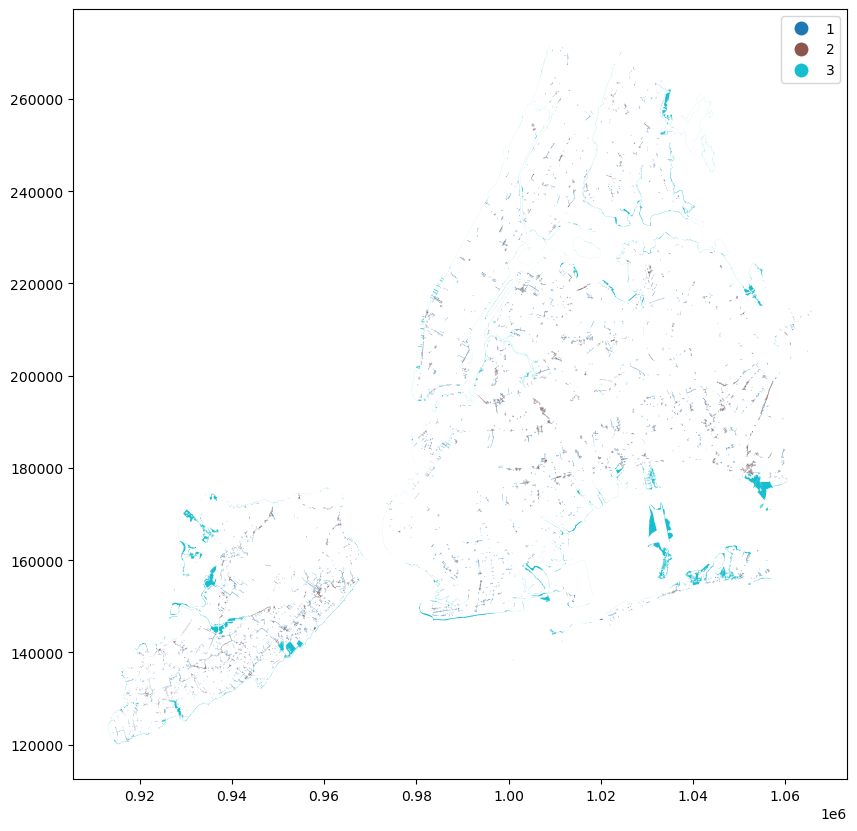

In [7]:
flood_2050.plot('Flooding_Category',
                figsize=(10,10),
                legend=True,
                categorical=True)

For now, let's just use **Category 1 "Nuisance Flooding"** to simplify this calculation. I'm going to create a new gdf called `flood_2020_cat1` 

In [8]:
flood_2050_cat1 = flood_2050[flood_2050['Flooding_Category'] == 1]

## 1.2 `.overlay()`
We'll want to estimate the **percentage of the neighborhood at risk of all categories of flooding**. The first step is to do the following: 
1. Check the CRS between our two layers to make sure they are the same. 
2. Find the **Intersection** of geometries, using the `.overlay()`, function between the neighborhoods and the flood zones: That is we'll want to find the shapes that overlap between the neighborhood and each flood zone. 

In [9]:
nta.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [10]:
flood_2050_cat1.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Looks like they are different: 
- `nta` is **EPSG:4326**
- `flood_2050` is **EPSG:2263**

Notice that EPSG:2263 is in **feet**. Again, whenever we want to estimate areas, volumes, or lengths, we'll want to do this in a CRS in a unit that we can understand. (Areas in degrees doesn't make too much sense.) 

For now, let's convert the `nta` to **EPSG:2263** to have our measurements in **feet**. I'm going to create a new gdf `nta_2223`. 

In [11]:
nta_2263 = nta.to_crs(flood_2050_cat1.crs)

Finally, I want to create this overlay and assign it to a new gdf called `nta_2263_overlay_flood`. Note: This may take little bit of time as the `.overlay()` function is calculating all possible matches. Between geometries in `nta_2263` and `flood_2050_cat1`. (It took about 45 seconds on my computer.)

In [12]:
nta_2263_overlay_flood = gpd.overlay(nta_2263,flood_2050_cat1,how='intersection')

In [13]:
nta_2263_overlay_flood.head()

borocode  boroname countyfips ntacode               ntaname    shape_area  \
0       3.0  Brooklyn        047    BK43               Midwood  3.579964e+07   
1       3.0  Brooklyn        047    BK75               Bedford  3.262983e+07   
2       2.0     Bronx        005    BX40         Fordham South  6.307284e+06   
3       3.0  Brooklyn        047    BK88          Borough Park  5.400502e+07   
4       3.0  Brooklyn        047    BK96  Rugby-Remsen Village  3.270695e+07   

     shape_leng  Flooding_Category  Shape_Length    Shape_Area  \
0  27996.591274                  1  7.065402e+06  8.657528e+07   
1  29992.919174                  1  7.065402e+06  8.657528e+07   
2  15878.272921                  1  7.065402e+06  8.657528e+07   
3  39247.227722                  1  7.065402e+06  8.657528e+07   
4  30957.853395                  1  7.065402e+06  8.657528e+07   

                                            geometry  
0  MULTIPOLYGON Z (((997959.212 163942.904 0.000,...  
1  MULTIPOLYGON Z (((1000431.742 188044.950 0.000...  
2  MULTIPOLYGON Z (((1013268.542 251529.405 0.000...  
3  MULTIPOLYGON Z (((991202.861 163727.372 0.000,...  
4  MULTIPOLYGON Z (((1009305.635 177614.856 0.000...

## Q.1 Groupby-and-summarize (5 pts)
How many rows for each neighborhood are there? `nta_2263_overlay_flood`? 

In [14]:
## Count the rows for each neighborhoods
nta_2263_overlay_flood.groupby('ntacode').count()['borocode'].unique()

array([1])

Let's take a look at what resulted. We can see here that we have columns from both the neighborhoods and flood gdfs. 

In [15]:
nta_2263_overlay_flood.head()

borocode  boroname countyfips ntacode               ntaname    shape_area  \
0       3.0  Brooklyn        047    BK43               Midwood  3.579964e+07   
1       3.0  Brooklyn        047    BK75               Bedford  3.262983e+07   
2       2.0     Bronx        005    BX40         Fordham South  6.307284e+06   
3       3.0  Brooklyn        047    BK88          Borough Park  5.400502e+07   
4       3.0  Brooklyn        047    BK96  Rugby-Remsen Village  3.270695e+07   

     shape_leng  Flooding_Category  Shape_Length    Shape_Area  \
0  27996.591274                  1  7.065402e+06  8.657528e+07   
1  29992.919174                  1  7.065402e+06  8.657528e+07   
2  15878.272921                  1  7.065402e+06  8.657528e+07   
3  39247.227722                  1  7.065402e+06  8.657528e+07   
4  30957.853395                  1  7.065402e+06  8.657528e+07   

                                            geometry  
0  MULTIPOLYGON Z (((997959.212 163942.904 0.000,...  
1  MULTIPOLYGON Z (((1000431.742 188044.950 0.000...  
2  MULTIPOLYGON Z (((1013268.542 251529.405 0.000...  
3  MULTIPOLYGON Z (((991202.861 163727.372 0.000,...  
4  MULTIPOLYGON Z (((1009305.635 177614.856 0.000...

<AxesSubplot: >

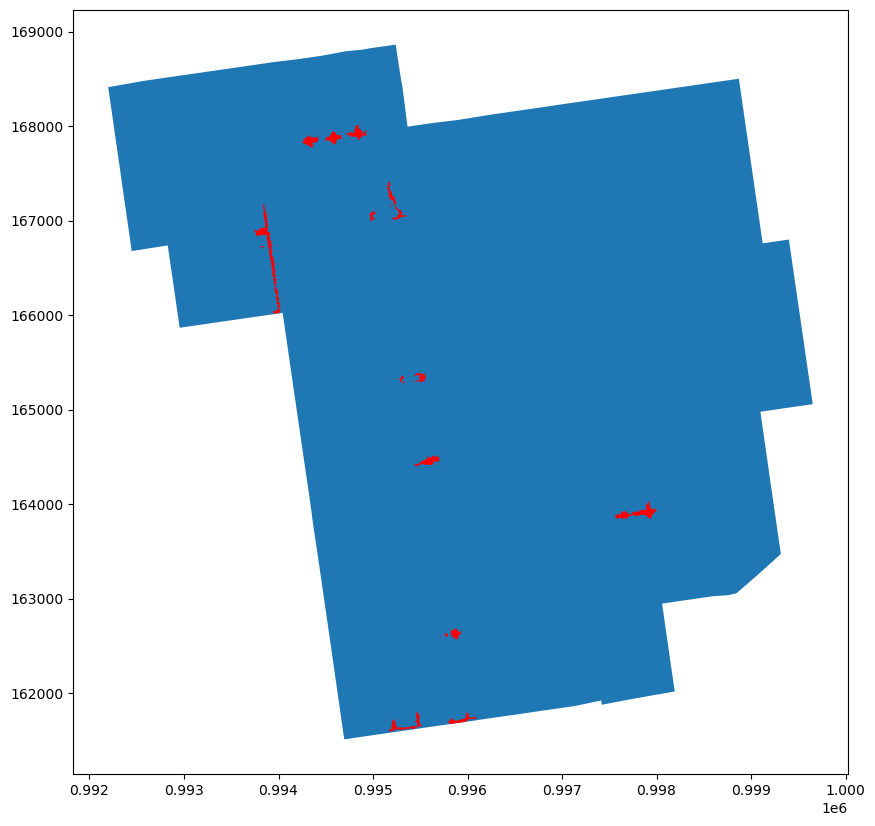

In [16]:
## I'm just going to select one neighborhood and see what this overlay looks like
fig1,ax1 = plt.subplots(1,1,figsize=(10,10))

## Plotting the neighborhood BK43
nta_2263[nta_2263['ntacode']=='BK43'].plot(ax=ax1)

## Plotting the flood zone intersecting with the neighborhood
nta_2263_overlay_flood[nta_2263_overlay_flood['ntacode']=='BK43'].plot(ax=ax1,color='red')

## 1.3 Find area percentage
For all neighborhoods, I'll want to find: 
$$
\% floodzone_{n} =\frac{A_{fn}}{A_{n}}
$$

where $n$ is a neighborhood, $A_{fn}$ is the area of the flood zone that intersects with that neighborhood $n$ and $A_n$ is the area of the neighorhood.

(Yes we can write mathematical notation in Markdown using LaTex! No, I won't make you do it if you aren't already familiar with LaTex.)

To do this, we'll need: 
- $A_{fn}$ 
- $A_n$

In [17]:
nta_2263_overlay_flood['area_flood'] = nta_2263_overlay_flood.area
nta_2263['area_neighb'] = nta_2263.area

## 1.4 Merge
I'm now going merge my `nta_2263_overlay_flood` gdf with the `nta_2263` because I want to divide `area_flood` and `area_neighb`. 
 

In [18]:
## Again I'm just going to select the two columns I need, the neighborhood code (to perform the merge) and the area of the flood zone (to calculate the percentage of the neighborhood that is flooded)
## I'm going to use a left join, so that I keep all the neighborhoods in the original dataset, 
## even if they don't intersect with the flood zone dataset

nta_2263_merged = nta_2263.merge(nta_2263_overlay_flood[['ntacode','area_flood']],on='ntacode',how='left')

Super! 

In [19]:
nta_2263_merged.head()

borocode  boroname countyfips ntacode               ntaname    shape_area  \
0       3.0  Brooklyn        047    BK43               Midwood  3.579964e+07   
1       3.0  Brooklyn        047    BK75               Bedford  3.262983e+07   
2       2.0     Bronx        005    BX40         Fordham South  6.307284e+06   
3       3.0  Brooklyn        047    BK88          Borough Park  5.400502e+07   
4       3.0  Brooklyn        047    BK96  Rugby-Remsen Village  3.270695e+07   

     shape_leng                                           geometry  \
0  27996.591274  POLYGON ((998870.807 168503.119, 998996.889 16...   
1  29992.919174  POLYGON ((1000351.303 194574.900, 999670.074 1...   
2  15878.272921  POLYGON ((1014295.119 253236.989, 1014383.000 ...   
3  39247.227722  POLYGON ((990897.900 169268.121, 990588.252 16...   
4  30957.853395  POLYGON ((1009623.354 176865.760, 1009376.458 ...   

    area_neighb     area_flood  
0  3.579964e+07  172189.627708  
1  3.262983e+07  853010.074002  
2  6.307284e+06   13425.316076  
3  5.400502e+07  122640.939602  
4  3.270695e+07  582202.028122

## 1.5 Calculate percentage
Lastly, we'll just have to calculate the percentage of the flood zone in each neighborhood. 


In [20]:
nta_2263_merged['perc_flood'] = nta_2263_merged['area_flood']/nta_2263_merged['area_neighb']

<AxesSubplot: >

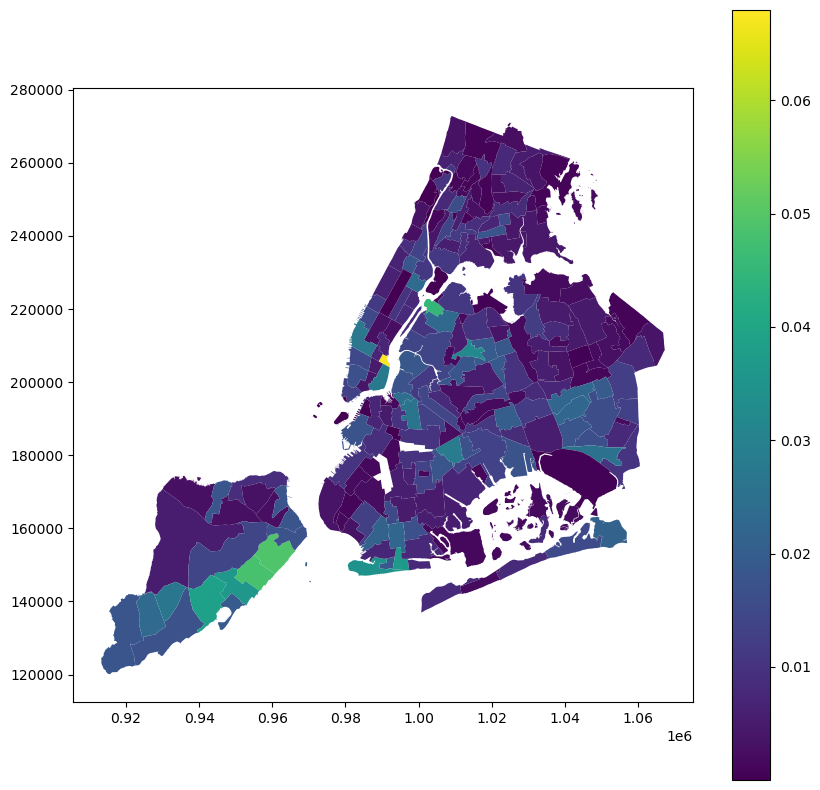

In [21]:
nta_2263_merged.plot(column='perc_flood', 
                        legend=True,
                        figsize=(10,10))

## Q.2 - Topical Knowledge (5 pts)
Here we used flood zone coverage in a neighborhood as proxy for flood. Why might this be an inexact estimate of flood risk? Propose and describe at least three factors we may not have considered in this analysis. 

Answer:

1. There are three flooding categories in the original data of 'NYC Stormwater Flood Map' and we just use the category 1 here, which means we didn't consider the other two categories of flood level.
2. Even inside one category, the 'covered' area may have different level of flood (because it's in a range rather than a single value), which indicates that using the coverage as a proxy is not always accurate.
3. Even with the same flood coverage, two neighborhoods may have different level of risk because of different population density, different soil type, and so on. There are many factors which contributes to the risk, and we just considered one of them here.

## 1.5 Re-classifying data
Now, instead of using the `perc_flood` column, I want to translate the values in this column into categories that might be more meaningful to a general audience. 

- We might consider binning our values into "Low", "Average", and "High" risk categories. How to determine these? The best approach is have some topical knowledge. For instance, we might read from research reports, look at previous flooding records of these neigbhohoods, etc, to acquire an understanding of how to bin values. 
- A less informed strategy could be to categorize by the distribution of our data. 

We'll take a the less informed strategy here for the sake of time: 

In [22]:
## Remember that the describe function gives us some basic statistics about the data
nta_2263_merged['perc_flood'].describe()

count    191.000000
mean       0.011292
std        0.010102
min        0.000019
25%        0.004067
50%        0.008491
75%        0.016422
max        0.067972
Name: perc_flood, dtype: float64

From the above, we'll use the following criteria: 
- Less than 25th percentile = Low
- 25-75th percentile = Average
- 75th percentile or higher = High

To express this in code. We will: 
- Create a new empty column 
- Filter our gdf based on each criteria
- Assign a different category to each criteria. 

### 1.5.1
First, let's create an empty string column.

In [23]:
# Remember that "" is an empty string
nta_2263_merged['risk_categories'] =""

See that we have a column called `risk_categories` that contains empty strings (note: not the same as `NaN`)

In [24]:
nta_2263_merged.head()

borocode  boroname countyfips ntacode               ntaname    shape_area  \
0       3.0  Brooklyn        047    BK43               Midwood  3.579964e+07   
1       3.0  Brooklyn        047    BK75               Bedford  3.262983e+07   
2       2.0     Bronx        005    BX40         Fordham South  6.307284e+06   
3       3.0  Brooklyn        047    BK88          Borough Park  5.400502e+07   
4       3.0  Brooklyn        047    BK96  Rugby-Remsen Village  3.270695e+07   

     shape_leng                                           geometry  \
0  27996.591274  POLYGON ((998870.807 168503.119, 998996.889 16...   
1  29992.919174  POLYGON ((1000351.303 194574.900, 999670.074 1...   
2  15878.272921  POLYGON ((1014295.119 253236.989, 1014383.000 ...   
3  39247.227722  POLYGON ((990897.900 169268.121, 990588.252 16...   
4  30957.853395  POLYGON ((1009623.354 176865.760, 1009376.458 ...   

    area_neighb     area_flood  perc_flood risk_categories  
0  3.579964e+07  172189.627708    0.004810                  
1  3.262983e+07  853010.074002    0.026142                  
2  6.307284e+06   13425.316076    0.002129                  
3  5.400502e+07  122640.939602    0.002271                  
4  3.270695e+07  582202.028122    0.017801

In [25]:
nta_2263_merged.sort_values(by='perc_flood')

borocode   boroname countyfips ntacode                         ntaname  \
79        1.0  Manhattan        061    MN35        Washington Heights North   
178       1.0  Manhattan        061    MN99     park-cemetery-etc-Manhattan   
132       3.0   Brooklyn        047    BK09    Brooklyn Heights-Cobble Hill   
94        3.0   Brooklyn        047    BK64                Prospect Heights   
194       4.0     Queens        081    QN98                         Airport   
..        ...        ...        ...     ...                             ...   
58        1.0  Manhattan        061    MN50  Stuyvesant Town-Cooper Village   
14        3.0   Brooklyn        047    BK41        Kensington-Ocean Parkway   
28        3.0   Brooklyn        047    BK40                 Windsor Terrace   
30        2.0      Bronx        005    BX98                   Rikers Island   
131       3.0   Brooklyn        047    BK63             Crown Heights South   

       shape_area     shape_leng  \
79   2.266231e+07   26623.873713   
178  9.154054e+07  155018.564315   
132  9.984670e+06   14253.675375   
94   1.024166e+07   15051.943023   
194  2.277617e+08  134833.935261   
..            ...            ...   
58   5.575232e+06   11000.158745   
14   1.589335e+07   20800.556075   
28   1.404161e+07   19033.540163   
30   1.815460e+07   18903.346271   
131  1.598989e+07   24192.455655   

                                              geometry   area_neighb  \
79   POLYGON ((1003963.363 255062.955, 1004148.487 ...  2.266231e+07   
178  MULTIPOLYGON (((981219.056 188655.316, 980940....  9.154076e+07   
132  POLYGON ((986367.735 190549.239, 985813.835 19...  9.984755e+06   
94   POLYGON ((992934.113 187750.879, 993255.225 18...  1.024178e+07   
194  MULTIPOLYGON (((1054434.340 171513.080, 105444...  2.277616e+08   
..                                                 ...           ...   
58   MULTIPOLYGON (((994681.406 203127.675, 994780....  5.575232e+06   
14   POLYGON ((991235.563 174509.977, 991257.634 17...  1.589335e+07   
28   POLYGON ((989842.548 179997.856, 989842.643 17...  1.404167e+07   
30   POLYGON ((1019454.697 225654.329, 1019451.101 ...  1.815483e+07   
131  POLYGON ((994980.161 183890.329, 995610.371 18...  1.598989e+07   

        area_flood  perc_flood risk_categories  
79      439.435564    0.000019                  
178   11600.538415    0.000127                  
132    1836.546782    0.000184                  
94     2479.636855    0.000242                  
194  111052.572059    0.000488                  
..             ...         ...             ...  
58   378960.025609    0.067972                  
14             NaN         NaN                  
28             NaN         NaN                  
30             NaN         NaN                  
131            NaN         NaN                  

[195 rows x 12 columns]

### 1.5.2 
Now we'll filter for each criteria

In [26]:
## I'm going to use .loc instead of the square bracket method to select the rows and columns I want to edit
## Remember that .loc is used to select rows and columns by label

## So I simultaneously select my filtering criteria for rows and the column I want to edit. 
## 0.004067 is the 25th percentile of the data
nta_2263_merged.loc[nta_2263_merged['perc_flood']<0.004067,'risk_categories'] = 'low'

## A lot of things are happening here: 
## 1. We're filtering for two conditions: Both >=25% and <=75% 
## 2. Because I have multiple conditions, I need to use the & operator to combine them 
## and use the () on each condition
## 3. I'm breaking up my code into multiple lines for readability with the \ character
nta_2263_merged.loc[(nta_2263_merged['perc_flood']>=0.004067)&\
                    (nta_2263_merged['perc_flood']<=0.016422),'risk_categories'] = 'average'

## Always make sure that you're not double counting your rows
## If you use a <=X condition, you'll need to use a >X condition
nta_2263_merged.loc[nta_2263_merged['perc_flood']>0.016422,'risk_categories'] = 'high'

In [27]:
nta_2263_merged.head()

borocode  boroname countyfips ntacode               ntaname    shape_area  \
0       3.0  Brooklyn        047    BK43               Midwood  3.579964e+07   
1       3.0  Brooklyn        047    BK75               Bedford  3.262983e+07   
2       2.0     Bronx        005    BX40         Fordham South  6.307284e+06   
3       3.0  Brooklyn        047    BK88          Borough Park  5.400502e+07   
4       3.0  Brooklyn        047    BK96  Rugby-Remsen Village  3.270695e+07   

     shape_leng                                           geometry  \
0  27996.591274  POLYGON ((998870.807 168503.119, 998996.889 16...   
1  29992.919174  POLYGON ((1000351.303 194574.900, 999670.074 1...   
2  15878.272921  POLYGON ((1014295.119 253236.989, 1014383.000 ...   
3  39247.227722  POLYGON ((990897.900 169268.121, 990588.252 16...   
4  30957.853395  POLYGON ((1009623.354 176865.760, 1009376.458 ...   

    area_neighb     area_flood  perc_flood risk_categories  
0  3.579964e+07  172189.627708    0.004810         average  
1  3.262983e+07  853010.074002    0.026142            high  
2  6.307284e+06   13425.316076    0.002129             low  
3  5.400502e+07  122640.939602    0.002271             low  
4  3.270695e+07  582202.028122    0.017801            high

<AxesSubplot: >

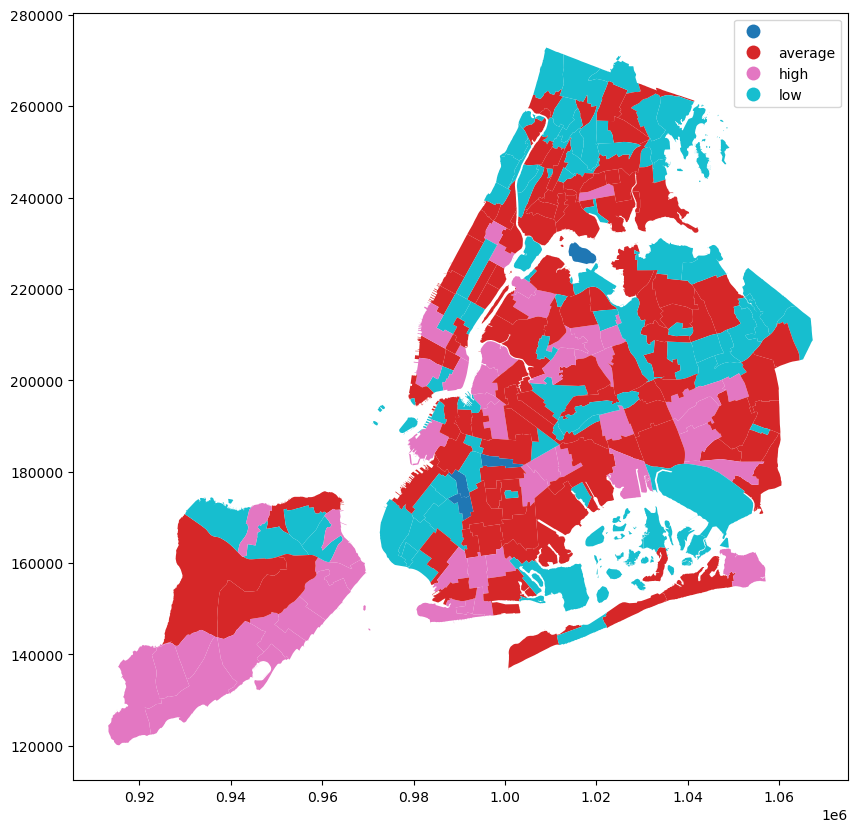

In [28]:
nta_2263_merged.plot(column='risk_categories', 
                        legend=True,
                        categorical=True,
                        figsize=(10,10))

## Q.3 - Missing data (2 pts)
Oops, what happened to those neighborhoods that weren't categorized? 

In [29]:
'''
Here in the plotted map we can see some of the neighborhoods are missing risk data.
That is because when we do a left merge, some of the neighborhoods are missing in the right table.
Here the right table is 'nta_2263_overlay_flood', which is the outcome of calculating the intersection overlay
of 'nta_2263' and 'flood_2050_cat1' (i.e., the neighborhoods and the category 1 of the 2050 flood map).
So the reason of the missing data is clear: Those missing neighborhoods don't intersect with the
category 1 of the 2050 flood map. So when we do the overlay, the records within those neighborhoods were removed.
''' 

## Here we filter which those neighborhoods are:
nta_2263_merged.loc[nta_2263_merged['perc_flood'].isna()==True]


borocode  boroname countyfips ntacode                   ntaname  \
14        3.0  Brooklyn        047    BK41  Kensington-Ocean Parkway   
28        3.0  Brooklyn        047    BK40           Windsor Terrace   
30        2.0     Bronx        005    BX98             Rikers Island   
131       3.0  Brooklyn        047    BK63       Crown Heights South   

       shape_area    shape_leng  \
14   1.589335e+07  20800.556075   
28   1.404161e+07  19033.540163   
30   1.815460e+07  18903.346271   
131  1.598989e+07  24192.455655   

                                              geometry   area_neighb  \
14   POLYGON ((991235.563 174509.977, 991257.634 17...  1.589335e+07   
28   POLYGON ((989842.548 179997.856, 989842.643 17...  1.404167e+07   
30   POLYGON ((1019454.697 225654.329, 1019451.101 ...  1.815483e+07   
131  POLYGON ((994980.161 183890.329, 995610.371 18...  1.598989e+07   

     area_flood  perc_flood risk_categories  
14          NaN         NaN                  
28          NaN         NaN                  
30          NaN         NaN                  
131         NaN         NaN

## Optional: Q.4 - Classifying Data (5 pts)
How would you recategorize those empty neighborhoods? Map the re-categorized data. 

<AxesSubplot: >

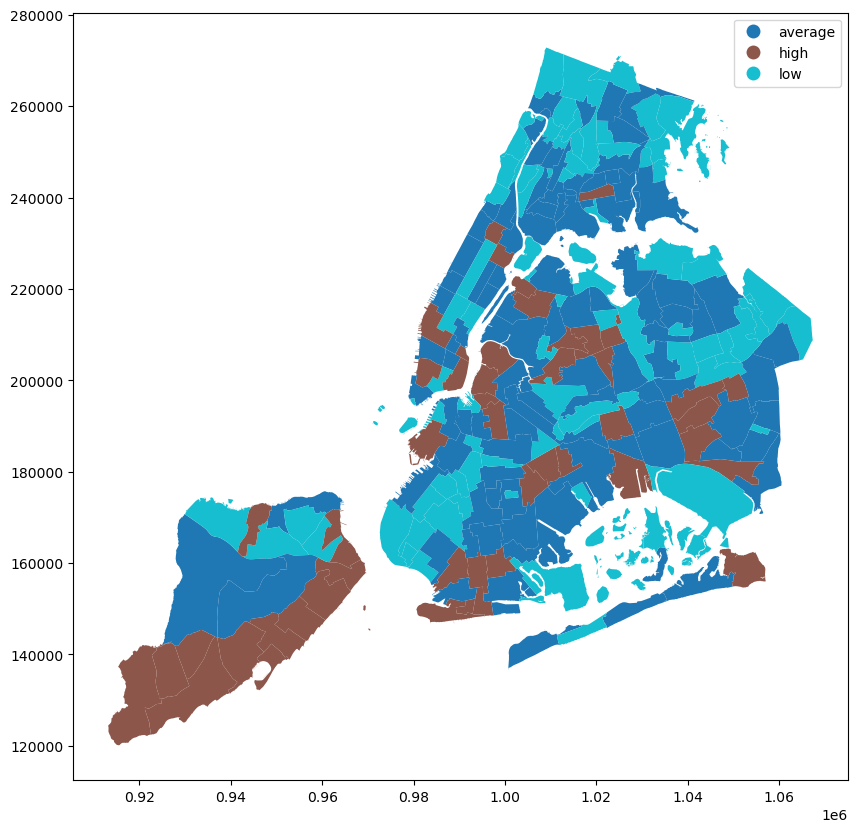

In [30]:
'''
The data of the listed four neighborhoods are missing because they don't intersect with the category 1 of
the 2050 flood map. Therefore, when we try to recategorize these neighborhoods, we should consider them as
'no' risk within the category. So we should fill the 'area_flood' as 0 and recalculate the
'perc_flood' and 'risk_categories'.
'''

## Replace the NaN in 'area_flood' as 0
nta_2263_merged.loc[nta_2263_merged['area_flood'].isna()==True,'area_flood'] = 0
## Recalculate the 'perc_flood'
nta_2263_merged['perc_flood'] = nta_2263_merged['area_flood']/nta_2263_merged['area_neighb']
## Regenerate the 'risk_categories'
nta_2263_merged.loc[nta_2263_merged['perc_flood']<0.004067,'risk_categories'] = 'low'
nta_2263_merged.loc[(nta_2263_merged['perc_flood']>=0.004067)&
                    (nta_2263_merged['perc_flood']<=0.016422),'risk_categories'] = 'average'
nta_2263_merged.loc[nta_2263_merged['perc_flood']>0.016422,'risk_categories'] = 'high'

## After refresing the data let's plot the map again
nta_2263_merged.plot(column='risk_categories', 
                        legend=True,
                        categorical=True,
                        figsize=(10,10))

## Q.5 (10pts) - Spatial join
- Download the [Points of Interest](https://data.cityofnewyork.us/City-Government/Points-Of-Interest/rxuy-2muj) dataset from the NYC OpenData portal
- Download the [NYCHA Developments](https://data.cityofnewyork.us/Housing-Development/Map-of-NYCHA-Developments/i9rv-hdr5) dataset again. 




For each NYCHA development, calculate the number of POIs within a 15 minute walkshed. Which development has the most POIs within a 15 minute walkshed? Which development has the least? 

In [31]:
## Read the downloaded data
poi = gpd.read_file('Points Of Interest.zip')
nycha_dev = gpd.read_file('Map of NYCHA Developments.zip')

In [32]:
## Show the first rows of POI
poi.head()

b7_sc  bin borough  complexid  date_creat    time_creat faci_dom  \
0  19743001  0.0       1        0.0  2009-05-14  00:00:00.000        9   
1  49731001  0.0       4     3378.0  2009-05-14  00:00:00.000        8   
2  39734001  0.0       3     3960.0  2009-05-14  00:00:00.000        8   
3  19795001  0.0       1        0.0  2009-05-14  00:00:00.000        8   
4  39740001  0.0       3        0.0  2009-05-14  00:00:00.000        8   

   facility_t  date_modif    time_modif        name  placeid  pri_add saftype  \
0         6.0  2011-11-18  00:00:00.000     HOLLAND    567.0      0.0       N   
1         6.0  2017-01-09  00:00:00.000  WHITESTONE    568.0      0.0       N   
2         6.0  2018-01-22  00:00:00.000    BROOKLYN    576.0      0.0       N   
3         6.0  2011-05-11  00:00:00.000   MANHATTAN    580.0      0.0       N   
4         6.0  2017-03-03  00:00:00.000     PULASKI    582.0      0.0       N   

   segmentid sos source                    geometry  
0    31895.0   1  DoITT  POINT (-74.00702 40.72463)  
1   306303.0   2  DoITT  POINT (-73.82662 40.79718)  
2   144842.0   2  DoITT  POINT (-73.99395 40.70385)  
3   162664.0   1  DoITT  POINT (-73.99194 40.70960)  
4   157362.0   1  DoITT  POINT (-73.95266 40.73907)

In [33]:
## Show the first rows of NYCHA developments
nycha_dev.head()

borough                   developmen tds_num  \
0      BRONX       1010 EAST 178TH STREET     180   
1  MANHATTAN                HOLMES TOWERS     159   
2   BROOKLYN       104-14 TAPSCOTT STREET     242   
3      BRONX  1162-1176 WASHINGTON AVENUE     233   
4  MANHATTAN    131 SAINT NICHOLAS AVENUE     154   

                                            geometry  
0  POLYGON ((-73.88092 40.84050, -73.88068 40.840...  
1  POLYGON ((-73.94445 40.78071, -73.94456 40.780...  
2  POLYGON ((-73.92039 40.66498, -73.92074 40.664...  
3  POLYGON ((-73.90694 40.83009, -73.90705 40.829...  
4  POLYGON ((-73.95286 40.80376, -73.95317 40.803...

In [34]:
## Re-assign the CRS
poi = poi.to_crs(epsg=3857)
nycha_dev = nycha_dev.to_crs(epsg=3857)

In [35]:
## Fix the column name
nycha_dev = nycha_dev.rename(columns={'developmen':'development'})

<AxesSubplot: >

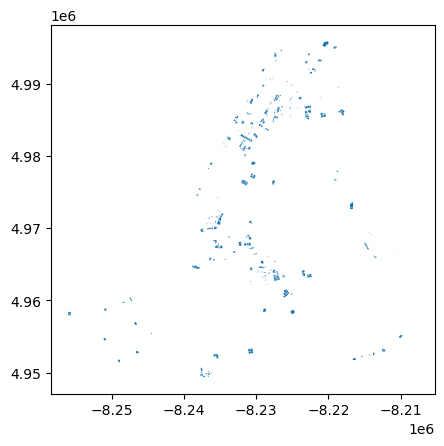

In [36]:
## Take a look at the NYCHA developments
nycha_dev.plot()

In [37]:
## Generate the 15 min walkshed
## A general 15 min walk is 1200 meters
nycha_dev_buffer = gpd.GeoDataFrame(
                                    nycha_dev[['borough', 'development', 'tds_num']], 
                                    crs = nycha_dev.crs, 
                                    geometry = nycha_dev.buffer(1200))

In [38]:
## Take a look at the buffer table
nycha_dev_buffer

borough                         development tds_num  \
0        BRONX              1010 EAST 178TH STREET     180   
1    MANHATTAN                       HOLMES TOWERS     159   
2     BROOKLYN              104-14 TAPSCOTT STREET     242   
3        BRONX         1162-1176 WASHINGTON AVENUE     233   
4    MANHATTAN           131 SAINT NICHOLAS AVENUE     154   
..         ...                                 ...     ...   
272  MANHATTAN                  WSUR (BROWNSTONES)     178   
273  MANHATTAN  WSUR (SITE A) 120 WEST 94TH STREET     151   
274  MANHATTAN   WSUR (SITE B) 74 WEST 92ND STREET     173   
275  MANHATTAN  WSUR (SITE C) 589 AMSTERDAM AVENUE     174   
276   BROOKLYN                     WYCKOFF GARDENS     163   

                                              geometry  
0    POLYGON ((-8225578.227 4988973.796, -8225576.0...  
1    POLYGON ((-8230875.518 4981098.723, -8230775.6...  
2    POLYGON ((-8227601.382 4963277.010, -8227584.8...  
3    POLYGON ((-8226810.299 4988414.898, -8226704.7...  
4    POLYGON ((-8231196.029 4983492.006, -8231196.5...  
..                                                 ...  
272  POLYGON ((-8235460.016 4981202.728, -8235466.5...  
273  POLYGON ((-8233652.071 4982737.569, -8233552.3...  
274  POLYGON ((-8233598.274 4982465.446, -8233498.4...  
275  POLYGON ((-8234074.258 4982369.134, -8233974.4...  
276  POLYGON ((-8235155.392 4966727.910, -8235053.4...  

[277 rows x 4 columns]

<AxesSubplot: >

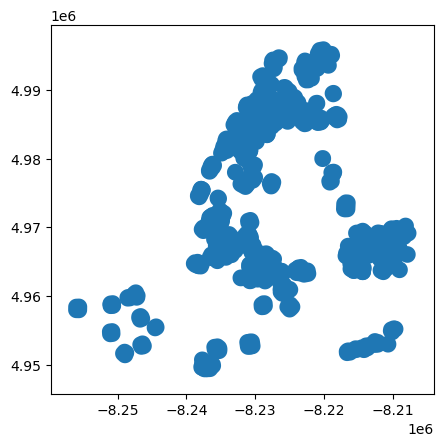

In [39]:
## Take a look at the buffer zone
nycha_dev_buffer.plot()

<AxesSubplot: >

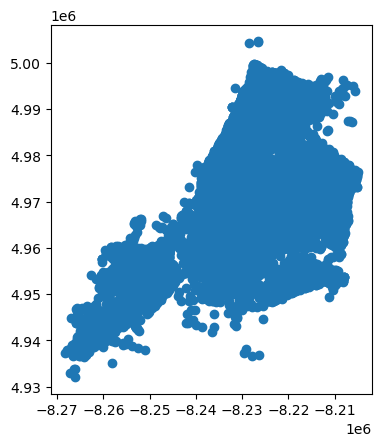

In [40]:
## Take a look at the POIs
poi.plot()

In [41]:
## Do the spatial join
poi_within_nycha_dev_buffer = gpd.sjoin(nycha_dev_buffer, poi, how='left')

In [42]:
## Count all the instances of each column value per development
poi_within_nycha_dev_buffer.groupby('development').count()

borough_left  tds_num  geometry  \
development                                                           
1010 EAST 178TH STREET                       150      150       150   
104-14 TAPSCOTT STREET                       183      183       183   
1162-1176 WASHINGTON AVENUE                  269      269       269   
131 SAINT NICHOLAS AVENUE                    268      268       268   
1471 WATSON AVENUE                           114      114       114   
...                                          ...      ...       ...   
WSUR (BROWNSTONES)                           310      310       310   
WSUR (SITE A) 120 WEST 94TH STREET           267      267       267   
WSUR (SITE B) 74 WEST 92ND STREET            257      257       257   
WSUR (SITE C) 589 AMSTERDAM AVENUE           240      240       240   
WYCKOFF GARDENS                              176      176       176   

                                    index_right  b7_sc  bin  borough_right  \
development                                                                  
1010 EAST 178TH STREET                      150    104  150            150   
104-14 TAPSCOTT STREET                      183     58  183            183   
1162-1176 WASHINGTON AVENUE                 269    166  269            269   
131 SAINT NICHOLAS AVENUE                   268    126  268            268   
1471 WATSON AVENUE                          114     89  114            114   
...                                         ...    ...  ...            ...   
WSUR (BROWNSTONES)                          310    102  310            310   
WSUR (SITE A) 120 WEST 94TH STREET          267     85  267            267   
WSUR (SITE B) 74 WEST 92ND STREET           257     74  257            257   
WSUR (SITE C) 589 AMSTERDAM AVENUE          240     54  240            240   
WYCKOFF GARDENS                             176     79  176            176   

                                    complexid  date_creat  time_creat  ...  \
development                                                            ...   
1010 EAST 178TH STREET                    150         150         150  ...   
104-14 TAPSCOTT STREET                    183         183         183  ...   
1162-1176 WASHINGTON AVENUE               269         269         269  ...   
131 SAINT NICHOLAS AVENUE                 268         268         268  ...   
1471 WATSON AVENUE                        114         114         114  ...   
...                                       ...         ...         ...  ...   
WSUR (BROWNSTONES)                        310         310         310  ...   
WSUR (SITE A) 120 WEST 94TH STREET        267         267         267  ...   
WSUR (SITE B) 74 WEST 92ND STREET         257         257         257  ...   
WSUR (SITE C) 589 AMSTERDAM AVENUE        240         240         240  ...   
WYCKOFF GARDENS                           176         176         176  ...   

                                    facility_t  date_modif  time_modif  name  \
development                                                                    
1010 EAST 178TH STREET                     150         148         148   150   
104-14 TAPSCOTT STREET                     183         175         175   183   
1162-1176 WASHINGTON AVENUE                269         259         259   269   
131 SAINT NICHOLAS AVENUE                  268         255         255   268   
1471 WATSON AVENUE                         114         105         105   114   
...                                        ...         ...         ...   ...   
WSUR (BROWNSTONES)                         310         299         299   310   
WSUR (SITE A) 120 WEST 94TH STREET         267         260         260   267   
WSUR (SITE B) 74 WEST 92ND STREET          257         250         250   257   
WSUR (SITE C) 589 AMSTERDAM AVENUE         240         232         232   240   
WYCKOFF GARDENS                            176         163         163   176   

                                    place

In [43]:
## Store the counts to a new variable
poi_counts = poi_within_nycha_dev_buffer.groupby('development').count()['bin']

In [44]:
## join the counts to the buffer DataFrame
nycha_dev_buffer = nycha_dev_buffer.merge(poi_counts, left_on='development', right_index=True)

In [45]:
## Rename the column
nycha_dev_buffer = nycha_dev_buffer.rename(columns={'bin':'poi_count'})

In [46]:
## Take a look at the table
nycha_dev_buffer

borough                         development tds_num  \
0        BRONX              1010 EAST 178TH STREET     180   
1    MANHATTAN                       HOLMES TOWERS     159   
2     BROOKLYN              104-14 TAPSCOTT STREET     242   
3        BRONX         1162-1176 WASHINGTON AVENUE     233   
4    MANHATTAN           131 SAINT NICHOLAS AVENUE     154   
..         ...                                 ...     ...   
272  MANHATTAN                  WSUR (BROWNSTONES)     178   
273  MANHATTAN  WSUR (SITE A) 120 WEST 94TH STREET     151   
274  MANHATTAN   WSUR (SITE B) 74 WEST 92ND STREET     173   
275  MANHATTAN  WSUR (SITE C) 589 AMSTERDAM AVENUE     174   
276   BROOKLYN                     WYCKOFF GARDENS     163   

                                              geometry  poi_count  
0    POLYGON ((-8225578.227 4988973.796, -8225576.0...        150  
1    POLYGON ((-8230875.518 4981098.723, -8230775.6...        181  
2    POLYGON ((-8227601.382 4963277.010, -8227584.8...        183  
3    POLYGON ((-8226810.299 4988414.898, -8226704.7...        269  
4    POLYGON ((-8231196.029 4983492.006, -8231196.5...        268  
..                                                 ...        ...  
272  POLYGON ((-8235460.016 4981202.728, -8235466.5...        310  
273  POLYGON ((-8233652.071 4982737.569, -8233552.3...        267  
274  POLYGON ((-8233598.274 4982465.446, -8233498.4...        257  
275  POLYGON ((-8234074.258 4982369.134, -8233974.4...        240  
276  POLYGON ((-8235155.392 4966727.910, -8235053.4...        176  

[277 rows x 5 columns]

In [47]:
## Get the NYCHA development(s) that has the most POIs in the 15 min walkshed
poi_counts_max = nycha_dev_buffer['poi_count'].sort_values().iloc[-1]
nycha_dev_buffer[nycha_dev_buffer['poi_count'] == poi_counts_max]

borough                        development tds_num  \
101    None  FHA REPOSSESSED HOUSES (GROUP IX)     283   

                                              geometry  poi_count  
101  MULTIPOLYGON (((-8210484.820 4963816.645, -821...        819

In [48]:
## Get the NYCHA development(s) that has the least POIs in the 15 min walkshed
poi_counts_min = nycha_dev_buffer['poi_count'].sort_values().iloc[1]
nycha_dev_buffer[nycha_dev_buffer['poi_count'] == poi_counts_min]

borough development tds_num  \
26   STATEN ISLAND       BERRY     052   
244  STATEN ISLAND   TODT HILL     042   

                                              geometry  poi_count  
26   POLYGON ((-8248817.250 4950217.154, -8248925.5...         34  
244  POLYGON ((-8251134.897 4956008.130, -8251068.9...         34